#                          Classifier with data augmentation

:### Get the Cats and Dogs dataset from google

In [ ]:
!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   /tmp/cats_and_dogs_filtered.zip

--2022-04-28 08:18:58--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.120.128, 74.125.70.128, 74.125.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   206MB/s    in 0.3s    

2022-04-28 08:18:59 (206 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### Path for train and validation datasets
Create multiple paths for difrent dataset directories to be used in data augmentation section below

In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
  
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')

train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')

validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

### Data Generator for transformation

The easiest way to apply transformation in keras is to use the ImageDataGenerator provided which lets u easily pick the values and the diffrent transformation you want to apply

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2, #a shear mapping is a linear map that displaces each point in a fixed direction
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

### Plotting Transformed images

this only for the purpose of showing and plotting the concept of imageDataGenerator 


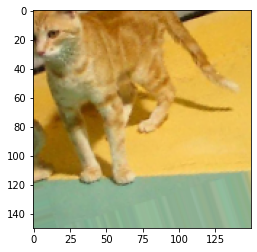

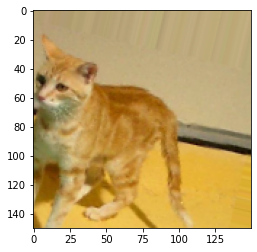

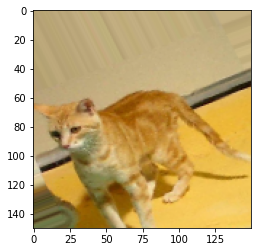

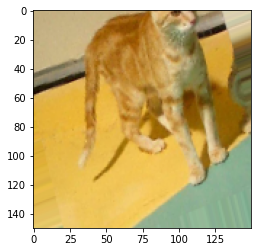

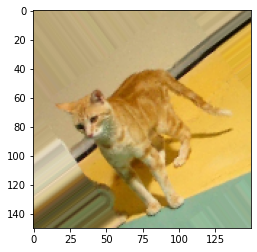

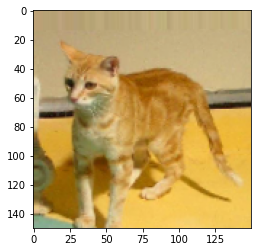

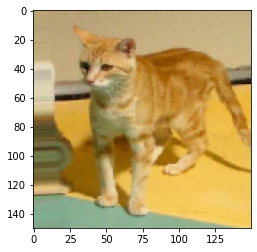

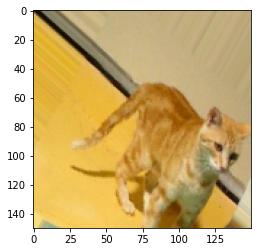

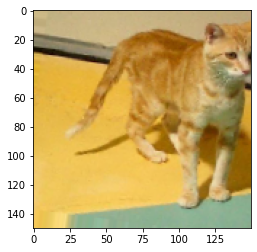

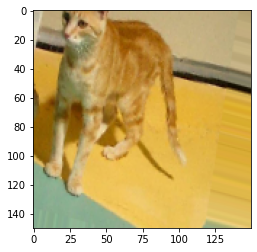

In [ ]:
%matplotlib inline 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img


img_path = os.path.join(train_cats_dir, train_cat_fnames[5])
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  
x = x.reshape((1,) + x.shape)

#break it at 10 iter since .flow method is infininte
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i == 10: #apply 10 transformation to just picture#5
    break

### Data generator for train and test

Here we build the actual transfomer that we will going to be using in the train and test 


In [ ]:
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,)

# note here that for validation images are only resized
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150), 
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


If we train a new network using this data augmentation configuration, our network will never see the same input twice. However the inputs that it sees are still heavily intercorrelated, so this might not be quite enough to completely get rid of overfitting.

### The Clasifier Model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop


img_input = layers.Input(shape=(150, 150, 3))

 
#here default stride is 2 so output is 148 - 2 / 2 + 1
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x) 

x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
#The Dropout layer randomly sets input units to 0 with a frequency of rate at each 
#step during training time, which helps prevent overfitting. Inputs not set to 0 are
#scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# compile the model
model = Model(img_input, output)


model.compile(loss='binary_crossentropy',
            optimizer='adam',
           metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496 

### Fit the model

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100, #nb od samples per batch size (100 * 20 = 2000)
      epochs=1000,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

### Track accuracy for training and validation

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss') 

Validation accuracy is 76%, that s why we are implementing a GAN to make it better and have more data